In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mintpy.utils import readfile, utils as ut 
import h5py
from datetime import datetime

import datetime as dtt
from mintpy.objects import timeseries
from mintpy.utils import time_func, readfile, utils as ut
from mintpy.dem_error import read_exclude_date, read_geometry
from scipy import linalg, stats
from miaplpy.simulation import simulate_noise
from miaplpy.lib.utils import est_corr_py
from scipy.linalg import lapack as lap
from scipy.linalg import pinv, pinv2
import miaplpy.find_short_baselines as fb
from scipy.spatial import Delaunay
from mintpy.utils import ptime
import datetime as dt
import matplotlib.dates as mdates
import random
out_dir = './out_figures'

In [4]:
ts_file = '/Users/Sara/Library/CloudStorage/OneDrive-UniversityofMiami/Miami_final/srtm_2/timeseries.h5'
geom_file = '/Users/Sara/Library/CloudStorage/OneDrive-UniversityofMiami/Miami_final/srtm_2/geometryRadar.h5'

out_dir = './out_figures'

# Sentinel

ts_obj = timeseries(ts_file)

date_list = ts_obj.get_date_list()
indx1 = date_list.index('20180108')
indx2 = date_list.index('20191229')
date_list = date_list[indx1:indx2]

metadata = ts_obj.get_metadata()
sin_inc_angle, range_dist, pbase = read_geometry(ts_file, geom_file, box=None)

pbase = pbase[indx1:indx2]

wavelength = np.float(metadata['radarWavelength'])
seconds = metadata.get('CENTER_LINE_UTC', 0)
tbase = np.array(ptime.date_list2tbase(date_list)[0], np.float32) / 365.25
tbase_diff = np.diff(tbase).reshape(-1, 1)

open geometry file: geometryRadar.h5
read 2D incidenceAngle, slantRangeDistance from geometry file: geometryRadar.h5
read mean bperp from timeseries file


In [ ]:
def invert_timeseries_L1(date_list, pairs, ifg_values, ref_date, percentage=[10, 30], wavelength=0.056, noise_range=1, sign='random'):
    rcond=1e-5
    model = dict()
    model['polynomial'] = 1
    model['periodic']   = []
    model['step']       = []
    model['exp']        = dict()
    model['log']        = dict()
    
    phase2range = -1 * float(wavelength) / (4.*np.pi)
    num_date = len(date_list)
    num_param = 2
    
    ts_data = np.zeros((len(date_list), len(percentage)))
    ts_data_L2 = np.zeros((len(date_list), len(percentage)))
    for pp in range(len(percentage)):
    
        d = int(percentage[pp]*len(pairs)/100)
        
        xind = random.sample(range(0, len(pairs)), d)
        
        nn = 2 
        noise = np.empty((d,))
        if sign == 'random':
            if d == 1:
                noise[1] = nn*np.pi
            else:
                indm = d//2
                noise[0:indm] = nn*np.pi
                noise[indm::] = -nn*np.pi
        elif sign == 'positive':
            noise[:] = nn*np.pi
        else:
            noise[:] = -nn*np.pi
        
            
        ifg = np.zeros(np.array(ifg_values).shape)
        ifg[:] = np.array(ifg_values)[:] 
        ifg[xind] += noise

        A, B, Alpha = get_design_matrix4timeseries(pairs, refDate=ref_date, alpha=0.001)
        X_L2, e2_L2 = linalg.lstsq(B, ifg, cond=rcond)[:2]
    
        ifg2 = np.zeros(ifg.shape)
        ifg = np.concatenate([ifg, ifg2]).flatten()
        #print(Alpha.shape, B.shape)
        B = np.concatenate([B, Alpha])
    
        
        W = np.eye((ifg.shape[0]))
        inv_Q = pinv2(np.matmul(np.matmul(np.transpose(B),W),B))
        Coef = np.matmul(np.matmul(np.transpose(B),W),ifg)
        X = np.matmul(inv_Q, Coef)
    
        res = np.abs(ifg - np.matmul(B,X))
        res[res<1e-7] = 1e-7
        max1 = np.empty(res.shape)
        max2 = np.empty(res.shape)
        max1[:] = res[:]
        max2[:] = 1
        diff_res = np.max(np.abs(max1 - max2))
        ii = 0
        while diff_res > 1e-8:   
            W = np.diag(1./res.flatten())
            W = W/np.max(W)
            inv_Q = pinv2(np.matmul(np.matmul(np.transpose(B),W),B))
            Coef = np.matmul(np.matmul(np.transpose(B),W),ifg)
            X = np.matmul(inv_Q, Coef)
            res = np.abs(ifg - np.matmul(B,X))
            res[res<1e-7] = 1e-7
            max2[:] = res[:]
            diff_res = np.max(np.abs(max1 - max2))
            ii += 1
            if ii > 5:
                break
            max1[:] = max2[:]

        #print('{} iteration for L1'.format(ii))
        ts_diff = X.reshape(-1,1) * tbase_diff
        ts_data[1:, pp] = np.cumsum(ts_diff.flatten(), axis=0)
        ts_data[1:, pp] *= phase2range
    
        ts_diff_L2 = X_L2.reshape(-1,1) * tbase_diff
        ts_data_L2[1:, pp] = np.cumsum(ts_diff_L2.flatten(), axis=0)
        ts_data_L2[1:, pp] *= phase2range
    
    
    return ts_data, ts_data_L2

def invert_timeseries_L1_seasonal(date_list, pairs, ifg_values, ref_date, wavelength=0.056, noise_range=1, sign='random'):
    rcond=1e-5
    model = dict()
    model['polynomial'] = 1
    model['periodic']   = []
    model['step']       = []
    model['exp']        = dict()
    model['log']        = dict()
    
    phase2range = -1 * float(wavelength) / (4.*np.pi)
    num_date = len(date_list)
    num_param = 2
    
    ts_data = np.zeros((len(date_list), ))
    ts_data_L2 = np.zeros((len(date_list), ))
    
    tt = [pair.split('_')[1] for pair in pairs]
    tt1 = np.array([datetime.strptime(im, '%Y%m%d').month for im in tt])
    tt2 = list(np.sort(np.concatenate((np.where(tt1==6)[0], np.where(tt1==7)[0], np.where(tt1==8)[0]))))
    
    d = len(tt2) 
        
    xind = random.sample(tt2, d)
    nn = 2 
    noise = np.empty((d,))
    if sign == 'random':
        if d == 1:
            noise[1] = nn*np.pi
        else:
            indm = d//2
            noise[0:indm] = nn*np.pi
            noise[indm::] = -nn*np.pi
    elif sign == 'positive':
        noise[:] = nn*np.pi
    else:
        noise[:] = -nn*np.pi
        
            
    ifg = np.zeros(np.array(ifg_values).shape).reshape(-1,1)
    ifg[:,0] = np.array(ifg_values)[:] 
    ifg[xind,0] += noise
    
    A, B, Alpha = get_design_matrix4timeseries(pairs, refDate=ref_date, alpha=0.001)
    X_L2, e2_L2 = linalg.lstsq(B, ifg, cond=rcond)[:2]
    
    ifg2 = np.zeros(ifg.shape)
    ifg = np.concatenate([ifg, ifg2]).flatten()
    B = np.concatenate([B, Alpha])
    W = np.eye((ifg.shape[0]))
    inv_Q = pinv(np.linalg.multi_dot([B.T, W, B]))
    Coef = np.linalg.multi_dot([B.T, W, ifg])
    X = np.matmul(inv_Q, Coef)
    
    res = np.abs(ifg - np.matmul(B,X))
    res[res<1e-6] = 1e-6
    max1 = np.empty(res.shape)
    max2 = np.empty(res.shape)
    max1[:] = res[:]
    max2[:] = 1
    diff_res = np.max(np.abs(max1 - max2))
    ii = 0
    max_iter = 100
    for ii in range(max_iter):
        if diff_res < 1e-2:   
            break
        W = np.diag(1./res.flatten())
        W = W/np.max(W)
        inv_Q = pinv(np.linalg.multi_dot([B.T, W, B]))
        Coef = np.linalg.multi_dot([B.T, W, ifg])
        X = np.matmul(inv_Q, Coef)
        res = np.abs(ifg - np.matmul(B,X))
        res[res<1e-6] = 1e-6
        max2[:] = res[:]
        diff_res = np.max(np.abs(max1 - max2))
        ii += 1
        max1[:] = max2[:]
    #print('{} iteration for L1'.format(ii))
    ts_diff = X.reshape(-1,1) * tbase_diff
    ts_data[1:] = np.cumsum(ts_diff.flatten(), axis=0)
    ts_data[1:,] *= phase2range
    
    ts_diff_L2 = X_L2.reshape(-1,1) * tbase_diff
    ts_data_L2[1:] = np.cumsum(ts_diff_L2.flatten(), axis=0)
    ts_data_L2[1:,] *= phase2range
    
    
    return ts_data, ts_data_L2


In [5]:
iterations = 1000

percentage = [10, 30]

legend = ['10%', '30%', 'No unwrap \nerror']
rep = 1

xx = [datetime.strptime(i, '%Y%m%d') for i in date_list]
xx = [(i - xx[0]).days for i in xx] 
#### single_reference

ts_data_si_l1, ts_data_si_l2 = invert_timeseries_L1(date_list, pairs_si, ifg_values_si, ref_date_si, 
                                                     percentage=[10, 30],  
                                                    wavelength=0.056, noise_range=1, sign='random')

sts_data_si_l1, sts_data_si_l2 = invert_timeseries_L1_seasonal(date_list, pairs_si, ifg_values_si, ref_date_si, 
                                                    wavelength=0.056, noise_range=1, sign='random')


delaunay_rate_std = np.zeros((12, iterations))
minis_rate_std = np.zeros((12, iterations))
seq_rate_std = np.zeros((12, iterations))
seq3_rate_std = np.zeros((12, iterations))
seq5_rate_std = np.zeros((12, iterations))
seq8_rate_std = np.zeros((12, iterations))

for it in range(iterations):
    print('iteration : ', it)
    #### delaunay

    ts_data_de_l1, ts_data_de_l2  = invert_timeseries_L1(date_list, pairs_de, ifg_values_de, ref_date_de, percentage=[10, 30], 
                                                         wavelength=0.056, noise_range=1, sign='random')

    sts_data_de_l1, sts_data_de_l2 = invert_timeseries_L1_seasonal(date_list, pairs_de, ifg_values_de, ref_date_de, 
                                                          wavelength=0.056, noise_range=1, sign='random')
     
    
    resl1_10 = stats.linregress(xx, ts_data_de_l1[:, 0])
    delaunay_rate_std[0, it] = resl1_10.slope*365.25    # cm/y
    delaunay_rate_std[6, it] = resl1_10.stderr*365.25   # cm/y
    resl2_10 = stats.linregress(xx, ts_data_de_l2[:, 0])
    delaunay_rate_std[1, it] = resl2_10.slope*365.25    # cm/y
    delaunay_rate_std[7, it] = resl2_10.stderr*365.25   # cm/y
    
    resl1_30 = stats.linregress(xx, ts_data_de_l1[:, 1])
    delaunay_rate_std[2, it] = resl1_30.slope*365.25    # cm/y
    delaunay_rate_std[8, it] = resl1_30.stderr*365.25   # cm/y
    resl2_30 = stats.linregress(xx, ts_data_de_l2[:, 1])
    delaunay_rate_std[3, it] = resl2_30.slope*365.25    # cm/y
    delaunay_rate_std[9, it] = resl2_30.stderr*365.25   # cm/y
    
    resl1_s = stats.linregress(xx, sts_data_de_l1)
    delaunay_rate_std[4, it] = resl1_s.slope*365.25    # cm/y
    delaunay_rate_std[10, it] = resl1_s.stderr*365.25   # cm/y
    resl2_s = stats.linregress(xx, sts_data_de_l2)
    delaunay_rate_std[5, it] = resl2_s.slope*365.25    # cm/y
    delaunay_rate_std[11, it] = resl2_s.stderr*365.25   # cm/y
    

    #### mini_stacks

    ts_data_mi_l1, ts_data_mi_l2 = invert_timeseries_L1(date_list, pairs_mi, ifg_values_mi, ref_date_mi, percentage=[10, 30],
                                                        wavelength=0.056, noise_range=1, sign='random')

    sts_data_mi_l1, sts_data_mi_l2 = invert_timeseries_L1_seasonal(date_list, pairs_mi, ifg_values_mi, ref_date_mi, 
                                                                   wavelength=0.056, noise_range=1, sign='random')

    resl1_10 = stats.linregress(xx, ts_data_mi_l1[:, 0])
    minis_rate_std[0, it] = resl1_10.slope*365.25    # cm/y
    minis_rate_std[6, it] = resl1_10.stderr*365.25   # cm/y
    resl2_10 = stats.linregress(xx, ts_data_mi_l2[:, 0])
    minis_rate_std[1, it] = resl2_10.slope*365.25    # cm/y
    minis_rate_std[7, it] = resl2_10.stderr*365.25   # cm/y
    
    resl1_30 = stats.linregress(xx, ts_data_mi_l1[:, 1])
    minis_rate_std[2, it] = resl1_30.slope*365.25    # cm/y
    minis_rate_std[8, it] = resl1_30.stderr*365.25   # cm/y
    resl2_30 = stats.linregress(xx, ts_data_mi_l2[:, 1])
    minis_rate_std[3, it] = resl2_30.slope*365.25    # cm/y
    minis_rate_std[9, it] = resl2_30.stderr*365.25   # cm/y
    
    resl1_s = stats.linregress(xx, sts_data_mi_l1)
    minis_rate_std[4, it] = resl1_s.slope*365.25    # cm/y
    minis_rate_std[10, it] = resl1_s.stderr*365.25   # cm/y
    resl2_s = stats.linregress(xx, sts_data_mi_l2)
    minis_rate_std[5, it] = resl2_s.slope*365.25    # cm/y
    minis_rate_std[11, it] = resl2_s.stderr*365.25   # cm/y
    
    
    #### sequential 1 connections

    ts_data_se_l1, ts_data_se_l2 = invert_timeseries_L1(date_list, pairs_se, ifg_values_se, ref_date_se, percentage=[10, 30],
                                                          wavelength=0.056, noise_range=1, sign='random')

    sts_data_se_l1, sts_data_se_l2 = invert_timeseries_L1_seasonal(date_list, pairs_se, ifg_values_se, ref_date_se, 
                                                                     wavelength=0.056, noise_range=1, sign='random')

    resl1_10 = stats.linregress(xx, ts_data_se_l1[:, 0])
    seq_rate_std[0, it] = resl1_10.slope*365.25    # cm/y
    seq_rate_std[6, it] = resl1_10.stderr*365.25   # cm/y
    resl2_10 = stats.linregress(xx, ts_data_se_l2[:, 0])
    seq_rate_std[1, it] = resl2_10.slope*365.25    # cm/y
    seq_rate_std[7, it] = resl2_10.stderr*365.25   # cm/y
    
    resl1_30 = stats.linregress(xx, ts_data_se_l1[:, 1])
    seq_rate_std[2, it] = resl1_30.slope*365.25    # cm/y
    seq_rate_std[8, it] = resl1_30.stderr*365.25   # cm/y
    resl2_30 = stats.linregress(xx, ts_data_se_l2[:, 1])
    seq_rate_std[3, it] = resl2_30.slope*365.25    # cm/y
    seq_rate_std[9, it] = resl2_30.stderr*365.25   # cm/y
    
    resl1_s = stats.linregress(xx, sts_data_se_l1)
    seq_rate_std[4, it] = resl1_s.slope*365.25    # cm/y
    seq_rate_std[10, it] = resl1_s.stderr*365.25   # cm/y
    resl2_s = stats.linregress(xx, sts_data_se_l2)
    seq_rate_std[5, it] = resl2_s.slope*365.25    # cm/y
    seq_rate_std[11, it] = resl2_s.stderr*365.25   # cm/y
    
    #### sequential 3 connections

    ts_data_se3_l1, ts_data_se3_l2 = invert_timeseries_L1(date_list, pairs_se3, ifg_values_se3, ref_date_se3, percentage=[10, 30],
                                                          wavelength=0.056, noise_range=1, sign='random')

    sts_data_se3_l1, sts_data_se3_l2 = invert_timeseries_L1_seasonal(date_list, pairs_se3, ifg_values_se3, ref_date_se3, 
                                                                     wavelength=0.056, noise_range=1, sign='random')

    resl1_10 = stats.linregress(xx, ts_data_se3_l1[:, 0])
    seq3_rate_std[0, it] = resl1_10.slope*365.25    # cm/y
    seq3_rate_std[6, it] = resl1_10.stderr*365.25   # cm/y
    resl2_10 = stats.linregress(xx, ts_data_se3_l2[:, 0])
    seq3_rate_std[1, it] = resl2_10.slope*365.25    # cm/y
    seq3_rate_std[7, it] = resl2_10.stderr*365.25   # cm/y
    
    resl1_30 = stats.linregress(xx, ts_data_se3_l1[:, 1])
    seq3_rate_std[2, it] = resl1_30.slope*365.25    # cm/y
    seq3_rate_std[8, it] = resl1_30.stderr*365.25   # cm/y
    resl2_30 = stats.linregress(xx, ts_data_se3_l2[:, 1])
    seq3_rate_std[3, it] = resl2_30.slope*365.25    # cm/y
    seq3_rate_std[9, it] = resl2_30.stderr*365.25   # cm/y
    
    resl1_s = stats.linregress(xx, sts_data_se3_l1)
    seq3_rate_std[4, it] = resl1_s.slope*365.25    # cm/y
    seq3_rate_std[10, it] = resl1_s.stderr*365.25   # cm/y
    resl2_s = stats.linregress(xx, sts_data_se3_l2)
    seq3_rate_std[5, it] = resl2_s.slope*365.25    # cm/y
    seq3_rate_std[11, it] = resl2_s.stderr*365.25   # cm/y
    
    #### sequential 5 connections

    ts_data_se5_l1, ts_data_se5_l2 = invert_timeseries_L1(date_list, pairs_se5, ifg_values_se5, ref_date_se5, percentage=[10, 30], 
                                                          wavelength=0.056, noise_range=1, sign='random')

    sts_data_se5_l1, sts_data_se5_l2 = invert_timeseries_L1_seasonal(date_list, pairs_se5, ifg_values_se5, ref_date_se5, 
                                                                     wavelength=0.056, noise_range=1, sign='random')

    resl1_10 = stats.linregress(xx, ts_data_se5_l1[:, 0])
    seq5_rate_std[0, it] = resl1_10.slope*365.25    # m/y
    seq5_rate_std[6, it] = resl1_10.stderr*365.25   # m/y
    resl2_10 = stats.linregress(xx, ts_data_se5_l2[:, 0])
    seq5_rate_std[1, it] = resl2_10.slope*365.25    # m/y
    seq5_rate_std[7, it] = resl2_10.stderr*365.25   # m/y
    
    resl1_30 = stats.linregress(xx, ts_data_se5_l1[:, 1])
    seq5_rate_std[2, it] = resl1_30.slope*365.25    # m/y
    seq5_rate_std[8, it] = resl1_30.stderr*365.25   # m/y
    resl2_30 = stats.linregress(xx, ts_data_se5_l2[:, 1])
    seq5_rate_std[3, it] = resl2_30.slope*365.25    # m/y
    seq5_rate_std[9, it] = resl2_30.stderr*365.25   # m/y
    
    resl1_s = stats.linregress(xx, sts_data_se5_l1)
    seq5_rate_std[4, it] = resl1_s.slope*365.25    # m/y
    seq5_rate_std[10, it] = resl1_s.stderr*365.25   # m/y
    resl2_s = stats.linregress(xx, sts_data_se5_l2)
    seq5_rate_std[5, it] = resl2_s.slope*365.25    # m/y
    seq5_rate_std[11, it] = resl2_s.stderr*365.25   # m/y
    
    #### sequential 8 connections

    ts_data_se8_l1, ts_data_se8_l2 = invert_timeseries_L1(date_list, pairs_se8, ifg_values_se8, ref_date_se8, percentage=[10, 30],
                                                          wavelength=0.056, noise_range=1, sign='random')

    sts_data_se8_l1, sts_data_se8_l2 = invert_timeseries_L1_seasonal(date_list, pairs_se8, ifg_values_se8, ref_date_se8, 
                                                                     wavelength=0.056, noise_range=1, sign='random')

    resl1_10 = stats.linregress(xx, ts_data_se8_l1[:, 0])
    seq8_rate_std[0, it] = resl1_10.slope*365.25    # m/y
    seq8_rate_std[6, it] = resl1_10.stderr*365.25   # m/y
    resl2_10 = stats.linregress(xx, ts_data_se8_l2[:, 0])
    seq8_rate_std[1, it] = resl2_10.slope*365.25    # m/y
    seq8_rate_std[7, it] = resl2_10.stderr*365.25   # m/y
    
    resl1_30 = stats.linregress(xx, ts_data_se8_l1[:, 1])
    seq8_rate_std[2, it] = resl1_30.slope*365.25    # m/y
    seq8_rate_std[8, it] = resl1_30.stderr*365.25   # m/y
    resl2_30 = stats.linregress(xx, ts_data_se8_l2[:, 1])
    seq8_rate_std[3, it] = resl2_30.slope*365.25    # m/y
    seq8_rate_std[9, it] = resl2_30.stderr*365.25   # m/y
    
    resl1_s = stats.linregress(xx, sts_data_se8_l1)
    seq8_rate_std[4, it] = resl1_s.slope*365.25    # m/y
    seq8_rate_std[10, it] = resl1_s.stderr*365.25   # m/y
    resl2_s = stats.linregress(xx, sts_data_se8_l2)
    seq8_rate_std[5, it] = resl2_s.slope*365.25    # m/y
    seq8_rate_std[11, it] = resl2_s.stderr*365.25   # m/y
    
    
#np.save('./simulation/delaunay_rate_std_z.npy', delaunay_rate_std)
#np.save('./simulation/minis_rate_std_z.npy', minis_rate_std)
#np.save('./simulation/seq_rate_std_z.npy', seq_rate_std)
#np.save('./simulation/seq3_rate_std_z.npy', seq3_rate_std)
#np.save('./simulation/seq5_rate_std_z.npy', seq5_rate_std)
#np.save('./simulation/seq8_rate_std_z.npy', seq8_rate_std)



NameError: name 'invert_timeseries_L1' is not defined

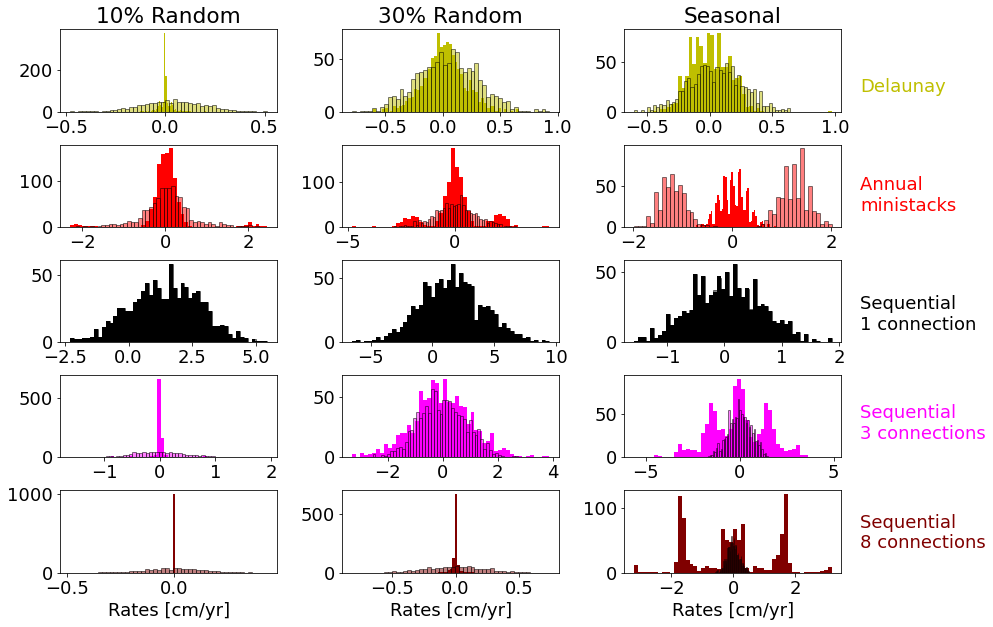

In [6]:
#import datetime
plt.rcParams["font.size"] = "18"
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
months = mdates.MonthLocator()
xx= [datetime.strptime(i, '%Y%m%d') for i in date_list]

off = 2*np.pi



colors=['y', 'red','black', 'magenta','maroon']

rmse_de = np.load('./simulation/delaunay_rate_std_z.npy')*100
rmse_mi = np.load('./simulation/minis_rate_std_z.npy')*100
rmse_se = np.load('./simulation/seq_rate_std_z.npy')*100
rmse_se3 = np.load('./simulation/seq3_rate_std_z.npy')*100
rmse_se8 = np.load('./simulation/seq8_rate_std_z.npy')*100



fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(14, 10))

## 10% random
axs[0,0].hist(rmse_de[0, :], 50, color=colors[0])
axs[0,0].hist(rmse_de[1, :], 50, color=colors[0], alpha=0.5, edgecolor='black')
#axs[0,0].legend(['L1-norm', 'L2-norm'])
axs[0,0].set_title('10% Random')

axs[1,0].hist(rmse_mi[0, :], 50, color=colors[1])
axs[1,0].hist(rmse_mi[1, :], 50, color=colors[1], alpha=0.5, edgecolor='black')

axs[2,0].hist(rmse_se[0, :], 50, color=colors[2])
axs[2,0].hist(rmse_se[1, :], 50, color=colors[2], alpha=0.5, edgecolor='black')

axs[3,0].hist(rmse_se3[0, :], 50, color=colors[3])
axs[3,0].hist(rmse_se3[1, :], 50, color=colors[3], alpha=0.5, edgecolor='black')

axs[4,0].hist(rmse_se8[0, :], 1, color=colors[4])
axs[4,0].hist(rmse_se8[1, :], 50, color=colors[4], alpha=0.5, edgecolor='black')

axs[4,0].set_xlabel('Rates [cm/yr]')

## 30% random
axs[0,1].hist(rmse_de[2, :], 50, color=colors[0])
axs[0,1].hist(rmse_de[3, :], 50, color=colors[0], alpha=0.5, edgecolor='black')
#axs[0,0].legend(['L1-norm', 'L2-norm'])
axs[0,1].set_title('30% Random')

axs[1,1].hist(rmse_mi[2, :], 50, color=colors[1])
axs[1,1].hist(rmse_mi[3, :], 50, color=colors[1], alpha=0.5, edgecolor='black')

axs[2,1].hist(rmse_se[2, :], 50, color=colors[2])
axs[2,1].hist(rmse_se[3, :], 50, color=colors[2], alpha=0.5, edgecolor='black')

axs[3,1].hist(rmse_se3[2, :], 50, color=colors[3])
axs[3,1].hist(rmse_se3[3, :], 50, color=colors[3], alpha=0.5, edgecolor='black')

axs[4,1].hist(rmse_se8[2, :], 20, color=colors[4])
axs[4,1].hist(rmse_se8[3, :], 50, color=colors[4], alpha=0.5, edgecolor='black')
axs[4,1].set_xlabel('Rates [cm/yr]')


## seasonal
axs[0,2].hist(rmse_de[4, :], 50, color=colors[0])
axs[0,2].hist(rmse_de[5, :], 50, color=colors[0], alpha=0.5, edgecolor='black')
#axs[0,0].legend(['L1-norm', 'L2-norm'])
axs[0,2].set_title('Seasonal')

axs[1,2].hist(rmse_mi[4, :], 50, color=colors[1])
axs[1,2].hist(rmse_mi[5, :], 50, color=colors[1], alpha=0.5, edgecolor='black')

axs[2,2].hist(rmse_se[4, :], 50, color=colors[2])
axs[2,2].hist(rmse_se[5, :], 50, color=colors[2], alpha=0.5, edgecolor='black')

axs[3,2].hist(rmse_se3[4, :], 50, color=colors[3])
axs[3,2].hist(rmse_se3[5, :], 50, color=colors[3], alpha=0.5, edgecolor='black')

axs[4,2].hist(rmse_se8[4, :], 50, color=colors[4])
axs[4,2].hist(rmse_se8[5, :], 50, color=colors[4], alpha=0.5, edgecolor='black')
axs[4,2].set_xlabel('Rates [cm/yr]')


labels = ['Delaunay', 'Annual \nministacks', 'Sequential \n1 connection', 'Sequential \n3 connections', 'Sequential \n8 connections']

#limits=[-5,10]
#for t in range(5):
#    for u in range(3):
#        axs[t, u].set_xlim(limits)
    

axs[0, 2].text(1.2, 20, labels[0], color=colors[0])
axs[0, 2].text(1.2, -100, labels[1], color=colors[1])
axs[0, 2].text(1.2, -220, labels[2], color=colors[2])
axs[0, 2].text(1.2, -330, labels[3], color=colors[3])
axs[0, 2].text(1.2, -440, labels[4], color=colors[4])


plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

#plt.savefig(out_dir +'/three_columns_error_prop', bbox_inches='tight', dpi=300) 
#plt.savefig(out_dir +'/Rates_histograms_prop', bbox_inches='tight', dpi=300) 


In [ ]:
iterations = 1000

percentage = [10, 30]

legend = ['10%', '30%', 'No unwrap \nerror']
rep = 1


#### single_reference

ts_data_si_l1, ts_data_si_l2 = invert_timeseries_L1(date_list, pairs_si, ifg_values_si, ref_date_si, 
                                                     percentage=[10, 30],  
                                                    wavelength=0.056, noise_range=1, sign='random')

sts_data_si_l1, sts_data_si_l2 = invert_timeseries_L1_seasonal(date_list, pairs_si, ifg_values_si, ref_date_si, 
                                                    wavelength=0.056, noise_range=1, sign='random')



delaunay_rmse = np.zeros((6, iterations))
minis_rmse = np.zeros((6, iterations))
seq_rmse = np.zeros((6, iterations))
seq3_rmse = np.zeros((6, iterations))
seq5_rmse = np.zeros((6, iterations))
seq8_rmse = np.zeros((6, iterations))


for it in range(iterations):
    print('iteration : ', it)
    #### delaunay

    ts_data_de_l1, ts_data_de_l2  = invert_timeseries_L1(date_list, pairs_de, ifg_values_de, ref_date_de, percentage=[10, 30], 
                                                         wavelength=0.056, noise_range=1, sign='random')

    sts_data_de_l1, sts_data_de_l2 = invert_timeseries_L1_seasonal(date_list, pairs_de, ifg_values_de, ref_date_de, 
                                                          wavelength=0.056, noise_range=1, sign='random')
     
    
    delaunay_rmse[0, it] = np.sqrt(np.sum((ts_data_de_l1[:,0]-disp_lin)**2)/(len(disp_lin)-1))*100  # L1 10%
    delaunay_rmse[1, it] = np.sqrt(np.sum((ts_data_de_l2[:,0]-disp_lin)**2)/(len(disp_lin)-1))*100  # L2 10%
    
    delaunay_rmse[2, it] = np.sqrt(np.sum((ts_data_de_l1[:,1]-disp_lin)**2)/(len(disp_lin)-1))*100  # L1 30%   
    delaunay_rmse[3, it] = np.sqrt(np.sum((ts_data_de_l2[:,1]-disp_lin)**2)/(len(disp_lin)-1))*100  # L2 30%
    
    delaunay_rmse[4, it] = np.sqrt(np.sum((sts_data_de_l1-disp_lin)**2)/(len(disp_lin)-1))*100  # L1 seasonal
    delaunay_rmse[5, it] = np.sqrt(np.sum((sts_data_de_l2-disp_lin)**2)/(len(disp_lin)-1))*100  # L2 seasonal

    #### mini_stacks

    ts_data_mi_l1, ts_data_mi_l2 = invert_timeseries_L1(date_list, pairs_mi, ifg_values_mi, ref_date_mi, percentage=[10, 30],
                                                        wavelength=0.056, noise_range=1, sign='random')

    sts_data_mi_l1, sts_data_mi_l2 = invert_timeseries_L1_seasonal(date_list, pairs_mi, ifg_values_mi, ref_date_mi, 
                                                                   wavelength=0.056, noise_range=1, sign='random')

    minis_rmse[0, it] = np.sqrt(np.sum((ts_data_mi_l1[:,0]-disp_lin)**2)/(len(disp_lin)-1))*100  # L1 10%
    minis_rmse[1, it] = np.sqrt(np.sum((ts_data_mi_l2[:,0]-disp_lin)**2)/(len(disp_lin)-1))*100  # L2 10%
    
    minis_rmse[2, it] = np.sqrt(np.sum((ts_data_mi_l1[:,1]-disp_lin)**2)/(len(disp_lin)-1))*100  # L1 30%   
    minis_rmse[3, it] = np.sqrt(np.sum((ts_data_mi_l2[:,1]-disp_lin)**2)/(len(disp_lin)-1))*100  # L2 30%
    
    minis_rmse[4, it] = np.sqrt(np.sum((sts_data_mi_l1-disp_lin)**2)/(len(disp_lin)-1))*100  # L1 seasonal
    minis_rmse[5, it] = np.sqrt(np.sum((sts_data_mi_l2-disp_lin)**2)/(len(disp_lin)-1))*100  # L2 seasonal
    
    
    #### sequential 1 connections

    ts_data_se_l1, ts_data_se_l2 = invert_timeseries_L1(date_list, pairs_se, ifg_values_se, ref_date_se, percentage=[10, 30],
                                                          wavelength=0.056, noise_range=1, sign='random')

    sts_data_se_l1, sts_data_se_l2 = invert_timeseries_L1_seasonal(date_list, pairs_se, ifg_values_se, ref_date_se, 
                                                                     wavelength=0.056, noise_range=1, sign='random')

    seq_rmse[0, it] = np.sqrt(np.sum((ts_data_se_l1[:,0]-disp_lin)**2)/(len(disp_lin)-1))*100  # L1 10%
    seq_rmse[1, it] = np.sqrt(np.sum((ts_data_se_l2[:,0]-disp_lin)**2)/(len(disp_lin)-1))*100  # L2 10%
    
    seq_rmse[2, it] = np.sqrt(np.sum((ts_data_se_l1[:,1]-disp_lin)**2)/(len(disp_lin)-1))*100  # L1 30%   
    seq_rmse[3, it] = np.sqrt(np.sum((ts_data_se_l2[:,1]-disp_lin)**2)/(len(disp_lin)-1))*100  # L2 30%
    
    seq_rmse[4, it] = np.sqrt(np.sum((sts_data_se_l1-disp_lin)**2)/(len(disp_lin)-1))*100  # L1 seasonal
    seq_rmse[5, it] = np.sqrt(np.sum((sts_data_se_l2-disp_lin)**2)/(len(disp_lin)-1))*100  # L2 seasonal
    
    #### sequential 3 connections

    ts_data_se3_l1, ts_data_se3_l2 = invert_timeseries_L1(date_list, pairs_se3, ifg_values_se3, ref_date_se3, percentage=[10, 30],
                                                          wavelength=0.056, noise_range=1, sign='random')

    sts_data_se3_l1, sts_data_se3_l2 = invert_timeseries_L1_seasonal(date_list, pairs_se3, ifg_values_se3, ref_date_se3, 
                                                                     wavelength=0.056, noise_range=1, sign='random')

    seq3_rmse[0, it] = np.sqrt(np.sum((ts_data_se3_l1[:,0]-disp_lin)**2)/(len(disp_lin)-1))*100  # L1 10%
    seq3_rmse[1, it] = np.sqrt(np.sum((ts_data_se3_l2[:,0]-disp_lin)**2)/(len(disp_lin)-1))*100  # L2 10%
    
    seq3_rmse[2, it] = np.sqrt(np.sum((ts_data_se3_l1[:,1]-disp_lin)**2)/(len(disp_lin)-1))*100  # L1 30%   
    seq3_rmse[3, it] = np.sqrt(np.sum((ts_data_se3_l2[:,1]-disp_lin)**2)/(len(disp_lin)-1))*100  # L2 30%
    
    seq3_rmse[4, it] = np.sqrt(np.sum((sts_data_se3_l1-disp_lin)**2)/(len(disp_lin)-1))*100  # L1 seasonal
    seq3_rmse[5, it] = np.sqrt(np.sum((sts_data_se3_l2-disp_lin)**2)/(len(disp_lin)-1))*100  # L2 seasonal
    
    #### sequential 5 connections

    ts_data_se5_l1, ts_data_se5_l2 = invert_timeseries_L1(date_list, pairs_se5, ifg_values_se5, ref_date_se5, percentage=[10, 30], 
                                                          wavelength=0.056, noise_range=1, sign='random')

    sts_data_se5_l1, sts_data_se5_l2 = invert_timeseries_L1_seasonal(date_list, pairs_se5, ifg_values_se5, ref_date_se5, 
                                                                     wavelength=0.056, noise_range=1, sign='random')

    seq5_rmse[0, it] = np.sqrt(np.sum((ts_data_se5_l1[:,0]-disp_lin)**2)/(len(disp_lin)-1))*100  # L1 10%
    seq5_rmse[1, it] = np.sqrt(np.sum((ts_data_se5_l2[:,0]-disp_lin)**2)/(len(disp_lin)-1))*100  # L2 10%
    
    seq5_rmse[2, it] = np.sqrt(np.sum((ts_data_se5_l1[:,1]-disp_lin)**2)/(len(disp_lin)-1))*100  # L1 30%   
    seq5_rmse[3, it] = np.sqrt(np.sum((ts_data_se5_l2[:,1]-disp_lin)**2)/(len(disp_lin)-1))*100  # L2 30%
    
    seq5_rmse[4, it] = np.sqrt(np.sum((sts_data_se5_l1-disp_lin)**2)/(len(disp_lin)-1))*100  # L1 seasonal
    seq5_rmse[5, it] = np.sqrt(np.sum((sts_data_se5_l2-disp_lin)**2)/(len(disp_lin)-1))*100  # L2 seasonal
    #### sequential 8 connections

    ts_data_se8_l1, ts_data_se8_l2 = invert_timeseries_L1(date_list, pairs_se8, ifg_values_se8, ref_date_se8, percentage=[10, 30],
                                                          wavelength=0.056, noise_range=1, sign='random')

    sts_data_se8_l1, sts_data_se8_l2 = invert_timeseries_L1_seasonal(date_list, pairs_se8, ifg_values_se8, ref_date_se8, 
                                                                     wavelength=0.056, noise_range=1, sign='random')

    seq8_rmse[0, it] = np.sqrt(np.sum((ts_data_se8_l1[:,0]-disp_lin)**2)/(len(disp_lin)-1))*100  # L1 10%
    seq8_rmse[1, it] = np.sqrt(np.sum((ts_data_se8_l2[:,0]-disp_lin)**2)/(len(disp_lin)-1))*100  # L2 10%
    
    seq8_rmse[2, it] = np.sqrt(np.sum((ts_data_se8_l1[:,1]-disp_lin)**2)/(len(disp_lin)-1))*100  # L1 30%   
    seq8_rmse[3, it] = np.sqrt(np.sum((ts_data_se8_l2[:,1]-disp_lin)**2)/(len(disp_lin)-1))*100  # L2 30%
    
    seq8_rmse[4, it] = np.sqrt(np.sum((sts_data_se8_l1-disp_lin)**2)/(len(disp_lin)-1))*100  # L1 seasonal
    seq8_rmse[5, it] = np.sqrt(np.sum((sts_data_se8_l2-disp_lin)**2)/(len(disp_lin)-1))*100  # L2 seasonal
    
    
#np.save('./simulation/delaunay_rmse_z.npy', delaunay_rmse)
#np.save('./simulation/minis_rmse_z.npy', minis_rmse)
#np.save('./simulation/seq_rmse_z.npy', seq_rmse)
#np.save('./simulation/seq3_rmse_z.npy', seq3_rmse)
#np.save('./simulation/seq5_rmse_z.npy', seq5_rmse)
#np.save('./simulation/seq8_rmse_Z.npy', seq8_rmse)

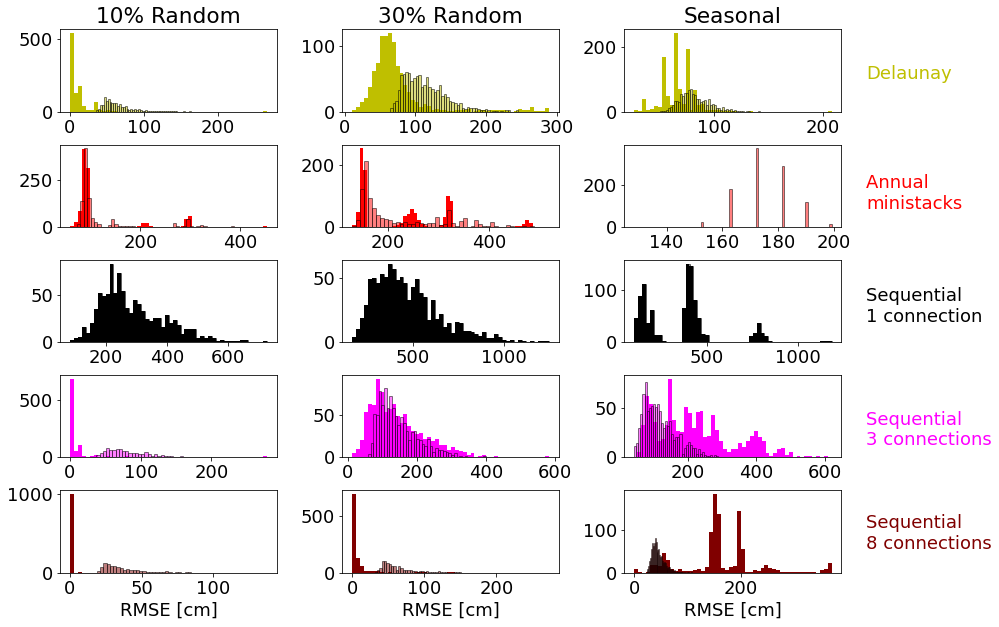

In [12]:
#import datetime
plt.rcParams["font.size"] = "18"
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
months = mdates.MonthLocator()
xx= [datetime.strptime(i, '%Y%m%d') for i in date_list]

off = 2*np.pi



colors=['y', 'red','black', 'magenta','maroon']

rmse_de = np.load('./simulation/delaunay_rmse_z.npy')*100
rmse_mi = np.load('./simulation/minis_rmse_z.npy')*100
rmse_se = np.load('./simulation/seq_rmse_z.npy')*100
rmse_se3 = np.load('./simulation/seq3_rmse_z.npy')*100
rmse_se8 = np.load('./simulation/seq8_rmse_Z.npy')*100



fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(14, 10))

## 10% random
axs[0,0].hist(rmse_de[0, :], 50, color=colors[0])
axs[0,0].hist(rmse_de[1, :], 50, color=colors[0], alpha=0.5, edgecolor='black')
#axs[0,0].legend(['L1-norm', 'L2-norm'])
axs[0,0].set_title('10% Random')

axs[1,0].hist(rmse_mi[0, :], 50, color=colors[1])
axs[1,0].hist(rmse_mi[1, :], 50, color=colors[1], alpha=0.5, edgecolor='black')

axs[2,0].hist(rmse_se[0, :], 50, color=colors[2])
axs[2,0].hist(rmse_se[1, :], 50, color=colors[2], alpha=0.5, edgecolor='black')

axs[3,0].hist(rmse_se3[0, :], 50, color=colors[3])
axs[3,0].hist(rmse_se3[1, :], 50, color=colors[3], alpha=0.5, edgecolor='black')

axs[4,0].hist(rmse_se8[0, :], 50, color=colors[4])
axs[4,0].hist(rmse_se8[1, :], 50, color=colors[4], alpha=0.5, edgecolor='black')

axs[4,0].set_xlabel('RMSE [cm]')

## 30% random
axs[0,1].hist(rmse_de[2, :], 50, color=colors[0])
axs[0,1].hist(rmse_de[3, :], 50, color=colors[0], alpha=0.5, edgecolor='black')
#axs[0,0].legend(['L1-norm', 'L2-norm'])
axs[0,1].set_title('30% Random')

axs[1,1].hist(rmse_mi[2, :], 50, color=colors[1])
axs[1,1].hist(rmse_mi[3, :], 50, color=colors[1], alpha=0.5, edgecolor='black')

axs[2,1].hist(rmse_se[2, :], 50, color=colors[2])
axs[2,1].hist(rmse_se[3, :], 50, color=colors[2], alpha=0.5, edgecolor='black')

axs[3,1].hist(rmse_se3[2, :], 50, color=colors[3])
axs[3,1].hist(rmse_se3[3, :], 50, color=colors[3], alpha=0.5, edgecolor='black')

axs[4,1].hist(rmse_se8[2, :], 50, color=colors[4])
axs[4,1].hist(rmse_se8[3, :], 50, color=colors[4], alpha=0.5, edgecolor='black')
axs[4,1].set_xlabel('RMSE [cm]')


## seasonal
axs[0,2].hist(rmse_de[4, :], 50, color=colors[0])
axs[0,2].hist(rmse_de[5, :], 50, color=colors[0], alpha=0.5, edgecolor='black')
#axs[0,0].legend(['L1-norm', 'L2-norm'])
axs[0,2].set_title('Seasonal')

axs[1,2].hist(rmse_mi[4, :], 50, color=colors[1])
axs[1,2].hist(rmse_mi[5, :], 50, color=colors[1], alpha=0.5, edgecolor='black')

axs[2,2].hist(rmse_se[4, :], 50, color=colors[2])
axs[2,2].hist(rmse_se[5, :], 50, color=colors[2], alpha=0.5, edgecolor='black')

axs[3,2].hist(rmse_se3[4, :], 50, color=colors[3])
axs[3,2].hist(rmse_se3[5, :], 50, color=colors[3], alpha=0.5, edgecolor='black')

axs[4,2].hist(rmse_se8[4, :], 50, color=colors[4])
axs[4,2].hist(rmse_se8[5, :], 50, color=colors[4], alpha=0.5, edgecolor='black')
axs[4,2].set_xlabel('RMSE [cm]')


labels = ['Delaunay', 'Annual \nministacks', 'Sequential \n1 connection', 'Sequential \n3 connections', 'Sequential \n8 connections']

#limits=[-5,10]
#for t in range(5):
#    for u in range(3):
#        axs[t, u].set_xlim(limits)
    

axs[0, 2].text(240.2, 100, labels[0], color=colors[0])
axs[0, 2].text(240.2, -300, labels[1], color=colors[1])
axs[0, 2].text(240.2, -650, labels[2], color=colors[2])
axs[0, 2].text(240.2, -1030, labels[3], color=colors[3])
axs[0, 2].text(240.2, -1350, labels[4], color=colors[4])


plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

#plt.savefig(out_dir +'/three_columns_error_prop', bbox_inches='tight', dpi=300) 
#plt.savefig(out_dir +'/RMSE_histograms_prop', bbox_inches='tight', dpi=300) 


In [16]:
import pandas as pd
#pd.set_option("display.precision", 2)
#pd.option_context('format.precision', 2)

def med_mad_avg_std(file, m=1):
    rmse = np.load(file)[0:6, :]*m
    rmse2 = np.zeros(rmse.shape)
    rmse2[0:2, :] = rmse[4:, :]
    rmse2[2:, :] = rmse[0:4, :]
    medx = np.median(rmse2, axis=1)
    madx = stats.median_abs_deviation(rmse2, axis=1)
    avgx = np.nanmean(rmse2, axis=1)
    stdx = np.std(rmse2, axis=1)
    return medx, madx, avgx, stdx
    
def highlight_col(x):
    blu = 'background-color: cornflowerblue'
    org = 'background-color: gold'
    grn = 'background-color: limegreen'
    df1 = pd.DataFrame('', index=x.index, columns=x.columns)
    df1.iloc[:, 0] = grn
    df1.iloc[:, 1] = grn
    df1.iloc[:, 2] = blu
    df1.iloc[:, 3] = blu
    df1.iloc[:, 4] = org
    df1.iloc[:, 5] = org
    return df1 

In [17]:
## Rates smoothing factor: 0.001
list1 = ['Seasonal L1', 'Seasonal L2', '10% random L1', '10% random L2', '30% random L1', '30% random L2']
medx, madx, avgx, stdx = med_mad_avg_std('./simulation/delaunay_rate_std_z.npy', m=100)
list2 = [ '{:.2f} +/- {:.2f}'.format(elem1, elem2) for elem1, elem2 in zip(medx, madx)]
medx, madx, avgx, stdx = med_mad_avg_std('./simulation/minis_rate_std_z.npy', m=100)
list3 = [ '{:.2f} +/- {:.2f}'.format(elem1, elem2) for elem1, elem2 in zip(medx, madx)]
medx, madx, avgx, stdx = med_mad_avg_std('./simulation/seq3_rate_std_z.npy', m=100)
list4 = [ '{:.2f} +/- {:.2f}'.format(elem1, elem2) for elem1, elem2 in zip(medx, madx)]
medx, madx, avgx, stdx = med_mad_avg_std('./simulation/seq5_rate_std_z.npy', m=100)
list5 = [ '{:.2f} +/- {:.2f}'.format(elem1, elem2) for elem1, elem2 in zip(medx, madx)]
medx, madx, avgx, stdx = med_mad_avg_std('./simulation/seq8_rate_std_z.npy', m=100)
list6 = [ '{:.2f} +/- {:.2f}'.format(elem1, elem2) for elem1, elem2 in zip(medx, madx)]
list0 = ['Unwrapping network', 'Delaunay', 'Annual ministacks', 'Sequential 3 connections', 
         'Sequential 5 connections', 'Sequential 8connections']
df = pd.DataFrame(list(zip(list1, list2, list3, list4, list5, list6)), 
                  columns =list0)

df = df.T
df.style.apply(highlight_col, axis=None)

,0,1,2,3,4,5
Unwrapping network,Seasonal L1,Seasonal L2,10% random L1,10% random L2,30% random L1,30% random L2
Delaunay,-0.00 +/- 0.11,0.05 +/- 0.15,0.00 +/- 0.00,0.04 +/- 0.11,0.01 +/- 0.10,0.04 +/- 0.18
Annual ministacks,0.02 +/- 0.17,0.92 +/- 0.67,0.02 +/- 0.14,0.05 +/- 0.28,-0.02 +/- 0.36,0.03 +/- 0.60
Sequential 3 connections,-0.06 +/- 1.18,-0.01 +/- 0.45,0.00 +/- 0.01,-0.00 +/- 0.34,-0.04 +/- 0.68,-0.04 +/- 0.59
Sequential 5 connections,-0.01 +/- 0.56,0.01 +/- 0.23,0.00 +/- 0.00,0.08 +/- 0.19,0.00 +/- 0.07,-0.00 +/- 0.32
Sequential 8connections,0.00 +/- 1.43,-0.02 +/- 0.13,0.00 +/- 0.00,0.00 +/- 0.09,-0.00 +/- 0.00,0.00 +/- 0.16


In [18]:
## RMSE smoothing factor: 0.001
list1 = ['Seasonal L1', 'Seasonal L2', '10% random L1', '10% random L2', '30% random L1', '30% random L2']
medx, madx, avgx, stdx = med_mad_avg_std('./simulation/delaunay_rmse_z.npy')
list2 = [ '{:.2f} +/- {:.2f}'.format(elem1, elem2) for elem1, elem2 in zip(medx, madx)]
medx, madx, avgx, stdx = med_mad_avg_std('./simulation/minis_rmse_z.npy')
list3 = [ '{:.2f} +/- {:.2f}'.format(elem1, elem2) for elem1, elem2 in zip(medx, madx)]
medx, madx, avgx, stdx = med_mad_avg_std('./simulation/seq3_rmse_z.npy')
list4 = [ '{:.2f} +/- {:.2f}'.format(elem1, elem2) for elem1, elem2 in zip(medx, madx)]
medx, madx, avgx, stdx = med_mad_avg_std('./simulation/seq5_rmse_z.npy')
list5 = [ '{:.2f} +/- {:.2f}'.format(elem1, elem2) for elem1, elem2 in zip(medx, madx)]
medx, madx, avgx, stdx = med_mad_avg_std('./simulation/seq8_rmse_Z.npy')
list6 = [ '{:.2f} +/- {:.2f}'.format(elem1, elem2) for elem1, elem2 in zip(medx, madx)]
list0 = ['Unwrapping network', 'Delaunay', 'Annual ministacks', 'Sequential 3 connections', 
         'Sequential 5 connections', 'Sequential 8connections']
df = pd.DataFrame(list(zip(list1, list2, list3, list4, list5, list6)), 
                  columns =list0)

df = df.T
df.style.apply(highlight_col, axis=None)

,0,1,2,3,4,5
Unwrapping network,Seasonal L1,Seasonal L2,10% random L1,10% random L2,30% random L1,30% random L2
Delaunay,0.64 +/- 0.10,0.80 +/- 0.09,0.03 +/- 0.03,0.58 +/- 0.10,0.63 +/- 0.13,1.07 +/- 0.19
Annual ministacks,1.28 +/- 0.00,1.73 +/- 0.09,0.86 +/- 0.05,0.91 +/- 0.05,2.25 +/- 0.76,1.73 +/- 0.24
Sequential 3 connections,2.02 +/- 0.73,1.09 +/- 0.32,0.02 +/- 0.01,0.76 +/- 0.20,1.29 +/- 0.48,1.32 +/- 0.35
Sequential 5 connections,1.97 +/- 0.55,0.64 +/- 0.14,0.00 +/- 0.00,0.48 +/- 0.11,0.20 +/- 0.13,0.85 +/- 0.21
Sequential 8connections,1.56 +/- 0.37,0.42 +/- 0.07,0.00 +/- 0.00,0.32 +/- 0.08,0.02 +/- 0.02,0.57 +/- 0.12
